# For image inference

In [29]:
%load_ext autoreload
%autoreload 2 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from collections import Counter
from sklearn.cluster import KMeans
from utils.color_classify import classify_white, visualize, visualize_video

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I0000 00:00:1719398751.802851 1170417 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro


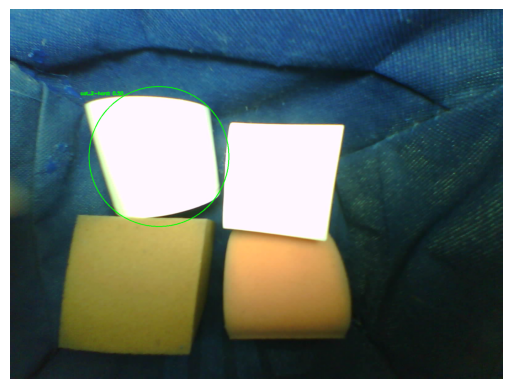

In [33]:
base_options = python.BaseOptions(model_asset_path='models/model_2class_int8_qat-2.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

IMAGE_FILE = 'data/train/images/picture161.jpg'
image = mp.Image.create_from_file(IMAGE_FILE)
image_np = image.numpy_view()

image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

detection_result = detector.detect(image)

classified_detections = classify_white(image_np, detection_result.detections)

image_copy = np.copy(image_np)
annotated_image = visualize(image_copy, classified_detections)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_annotated_image)
plt.axis('off')
plt.show()

## For Video Inference

In [35]:
input_path = 'data/videos/test3.mp4'
output_path = 'data/videos/new_test.mp4'
visualize_video(input_path, output_path)

I0000 00:00:1719398900.261951 1170417 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
